# Energy consumption of a Web Application Implemented in Different Programming Languages and Web Frameworks
*Probabilistic Programming 2025 Exam by Raúl Pardo ([raup@itu.dk](mailto:raup@itu.dk)) and Andrzej Wąsowski ([wasowski@itu.dk](mailto:wasowski@itu.dk))*<br/>
*version 1.0.0 2025-03-20 08:40*


In this exam, your task is to analyze energy consumption of different implementations of a web application.
The goal is to determine whether there are differences in energy consumption in different implementations of the web application or in its API endpoints.
This analysis is of utmost importance, as it might help software engineers to make informed choices that lower energy consumption. For instance, a plausible hypothesis is that lower level programming languages such as Rust consume less energy than higher level languages such as Python.
A preconception in this domain is that running time is the driving factor in energy consumption.
Are these true? The data in this exam and the analysis you will develop will allow to answer this type of questions.

## Data

The dataset contains $N = 1960$ measurements of energy consumption for different implementations and functionality of a web application. For each setup, there are 20 measurements. The dataset is in the file [dataset.csv](dataset.csv). The variables in the dataset are:

* **Application**. This variable has the form `<programming_language>-<web_framework>`. It specifies the programming language and web framework used in the experiment. For instance, `rust-actix` denotes the web framework Actix for the programming language Rust, or `c-sharp-razor` denotes the web framework Razor for the programming language C#.
    * Note that if a hypothesis involves only programming language, you need to extract it from the values in this variable.

* **Endpoint**. This variable refers to the API endpoints of the web application. For example, `/api/register` refers to the API endpoint used for registering users in the web application, or `/logout` is used for logging out of the system.

* **Runtime**. This variable indicates the time it took to process the request to the endpoint in seconds.

* **Energy consumption**. This variable indicates the energy consumed for processing the request to the endpoint in Joules.

Each row in the dataset is a measurement of the total energy consumed and runtime after processing a request in the corresponding API endpoint. The *Application* variable in each row indicates the web framework used for the measurement.

## Hypotheses

To analyze energy consumption in the different implementations, you must investigate the following hypotheses:

* **H1** - The web framework `c-sharp-razor` consumes more energy than any other web framework in the dataset.

* **H2** - The programming language `javascript` consumes the least amount of energy compared to any other programming language in the dataset.

* **H3** - Runtime has a stronger impact on energy consumption for some API endpoints than others. That is, the effect of runtime on energy consumption is larger for some API endpoints than others.

Your task is to use Bayesian Inference and Regression to decide whether these hypotheses hold, or possibly reject them. This includes:

* Loading, restructuring and transforming the data as needed.

* Designing Bayesian regression models and using inference algorithms to test the above hypotheses in PyMC.

* Explaining your model idea in English, preferably using a figure, and showing the Python code.

* Checking and reflecting (in writing) on the quality of the sampling process, considering warnings from the tool, sampling summary statistics, trace plots, and autocorrelation plots. Comment whether the quality of the sampled trace is good, and whether you had to make any adjustments during modeling and/or sampling.

* Visualizing the posterior information appropriately to address the hypotheses.
  

You should hand in a zip file with a Jupyter notebook and the data file (so that we can run it), and a **PDF file rendering of the Jupyter notebook**, so that your work can be assessed just by reading this file. It appears that the best PDF rendering is obtained by File / Export to HTML, and then saving/printing to PDF from your browser.

Make sure the notebook is actually a **report** readable to the examiners, especially to the censor who has not followed the course. The report should include:
* A brief introduction.
* Explanations on how data is loaded and cleaned.
* Explanations on analysis and model design (for each of the models you consider).
* A discussion of sampling quality (for each model) and all the plots that you present, and a reflection/decision on the outcome for each hypothesis.
* An overall conclusion.

**IMPORTANT:** For the tasks below, your code must accompany an explanation of its meaning and intended purpose. **Source code alone is not self-explanatory**. As mentioned above, you should also reflect on the results you get, e.g., highlighting issues with the data, or issues, pitfalls and assumptions of a model. **Exams containing only source code or very scarce explanations will result in low grades, including failing grades.**





## Minimum requirements 

1. Design a regression model to predict energy consumption using web framework as a predictor.
  
2. Analyze hypothesis H1 using the regression model in (1.).

## Ideas for extension

**Groups aiming at grade 7 and more should complete the following tasks:**
    
3. Analyze hypothesis H2, if necessary design a new model.
        
4. Perform prior predictive checks in all your models. Explain why the priors you selected are appropriate.
    
5. Perform posterior predictive checks in all your models. Discuss the results in the posterior predictive checks.
    
6. Discuss trace convergence in all your models.
    
**Groups aiming at grade 10 and higher should try 3-5 ideas from below or add some of your own:**

7. Analyze hypothesis H3, if necessary design a new model.
    
8. Perform a counterfactual analysis in your model for H3: For each endpoint, plot posterior predictions on energy consumption for a runtime value much larger than those in the dataset. Does this affect/introduce differences between energy consumption for different endpoints?
    
9. Design models with a transformation of the predicted variable, i.e., energy consumption. For instance, 
    * Build a model to analyze the probability that the energy consumption of a web framework is below 0.4 Joules. You may consider versions of this task involving other predictors.
    * Transform energy consumption into an ordinal variable representing an energy mark, e.g., an energy consumption in 0.0-0.2 is energy mark A, energy consumption in 0.2-0.4 is energy mark B and energy consumption of ≥ 0.4 is energy mark C. Use an ordinal regression model to analyze the energy mark of each framework. You may consider versions of this task involving other predictors.
    
10. Use information criteria to compare the models to analyze H1, H2 and H3.
    
11. Design a meaningful multilevel model in the context of these data.
   
12. Use causal reasoning to analyze causal relations between the variables in the dataset.

---

In [58]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import xarray as xr
import scipy.stats as stats
rng = 42

In [59]:
df = pd.read_csv('dataset.csv')

In [60]:
language, framework = list(zip(*df["application"].apply(lambda a: a.split("-") if not a.startswith("c-sharp") else [a[0:7], a[8:]])))
df["language"] = list(language)
df["framework"] = list(framework)

In [61]:
df

,application,endpoint,energy_consumption,runtime,language,framework
0,rust-actix,/api/register,0.449358,0.148812,rust,actix
1,rust-actix,/api/register,0.433871,0.148895,rust,actix
2,rust-actix,/api/register,0.270844,0.094729,rust,actix
3,rust-actix,/api/register,0.479776,0.163467,rust,actix
4,rust-actix,/api/register,0.268833,0.092300,rust,actix
...,...,...,...,...,...,...
1955,javascript-express,/logout,0.096436,0.032214,javascript,express
1956,javascript-express,/logout,0.097559,0.032214,javascript,express
1957,javascript-express,/logout,0.096922,0.032214,javascript,express
1958,javascript-express,/logout,0.097086,0.032214,javascript,express


Let's try to understand the data a little better.

/tmp/ipykernel_62382/1297375468.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(grouped, labels=labels, patch_artist=True)


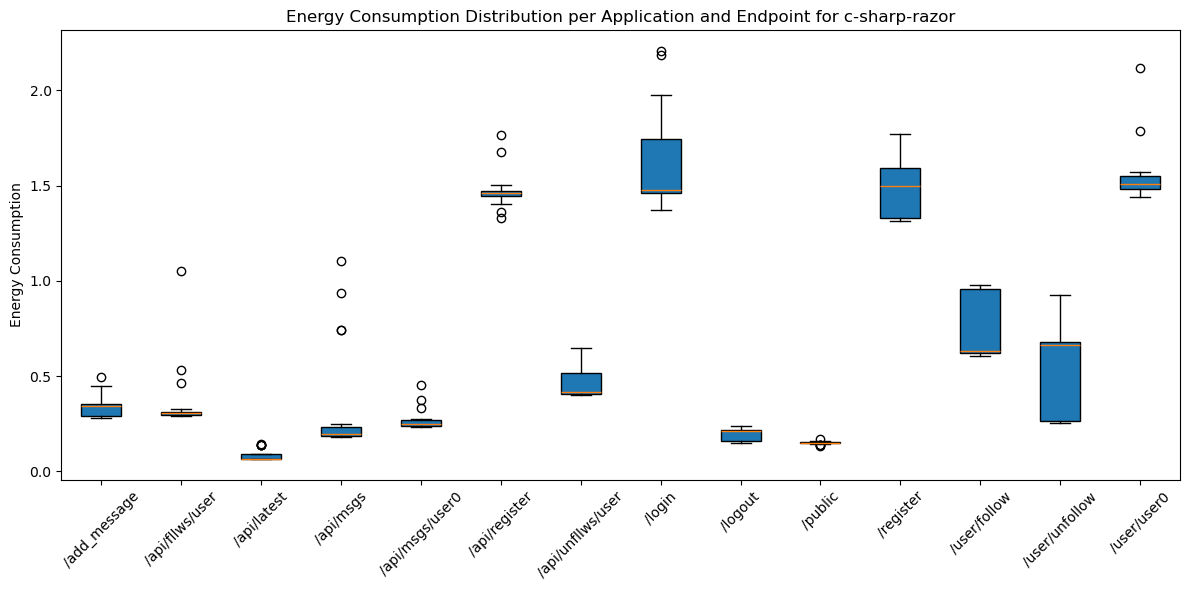

In [62]:
target = "c-sharp-razor"
csharpdata = df.where(df["application"] == target)
data = csharpdata
grouped = [ group["energy_consumption"].values for _, group in data.groupby(["endpoint"]) ]
labels = data.groupby(["endpoint"]).groups.keys()

plt.figure(figsize=(12, 6))
plt.boxplot(grouped, labels=labels, patch_artist=True)
plt.title(f"Energy Consumption Distribution per Application and Endpoint for {target}")
plt.ylabel("Energy Consumption")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


What a beautiful plot. But there seems to be some clear variance between consumption in endpoints within the same application.


## Testing Hypothesis 1

The first step will be to create a simple model with a single intercept per application. We will treat application as a categorical value. From here on we will refer to application A and consumption C.

Let's build a simple model:
$$
\begin{aligned}
    C &\sim \text{Normal}(\mu, \sigma) \\
    \mu &\sim \alpha_{[A[i]]} \\
    \alpha &\sim \text{Normal}(0,10) \\
    \sigma &\sim \text{Exponential}(1)
\end{aligned}
$$

We defined the prior for $\alpha$ as an extremely flat $\text{Normal}$ distribution because we don't have much prior knowledge of the energy consumption of different programming language and framework pairs.

The first step will be to create categorical values for the application column of the data:

In [63]:
cats = pd.Categorical(df["application"])
df["A"] = cats.codes
"c-sharp-razor code: ", cats.codes[cats == "c-sharp-razor"][0]

('c-sharp-razor code: ', 0)

Here we see that value 0 is "*c-sharp-razor*". We are now ready to create the PYMC model:

In [64]:
with pm.Model() as m_h1a:
    alpha = pm.Normal("alpha", 0, 10, shape=df["A"].unique().size)
    sigma = pm.Exponential("sigma", 1)

    C_data = pm.Data("C_data", df["energy_consumption"].values, mutable=True)
    A_data = pm.Data("A_data", df["A"].values, mutable=True)

    mu = pm.Deterministic("mu", alpha[A_data])
    C = pm.Normal("C", mu, sigma, observed=C_data)

    diff = pm.Deterministic("diff", alpha - alpha[0])

    trace_h1a = pm.sample(random_seed=rng)


/home/chobbie/anaconda3/envs/prpro-2025/lib/python3.12/site-packages/pymc/data.py:440: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Before proceeding with the analysis of hypothesis 1 we will first do a prior predictive check. First, we will have to sample some values from the prior using the `sample_prior_predictive` from PYMC. 

In [65]:
with m_h1a:
    trace_h1a.extend(pm.sample_prior_predictive(random_seed=rng))

Sampling: [C, alpha, sigma]


Next, we will plot it.

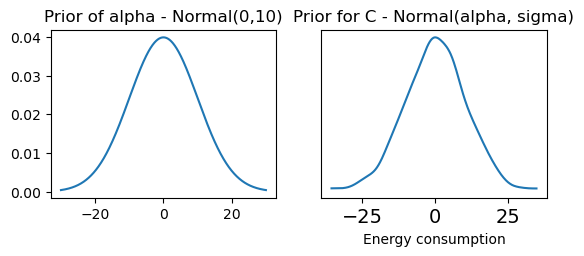

In [66]:
n_samples = 1000
ax1 = plt.subplot(2, 2, (1,1))
x = np.linspace(-30,30,n_samples)
alpha_sample = stats.norm.pdf(x, 0,10)
sigma_sample = stats.expon.pdf(x, 1)
ax1.plot(x, alpha_sample)
ax1.set_title("Prior of alpha - Normal(0,10)")

ax2 = plt.subplot(2, 2, (2,2))
alpha_sample = stats.norm.rvs(loc=0, scale=10, size=n_samples)
sigma_sample = stats.expon.rvs(1, size=n_samples)
prior_h = stats.norm.rvs(loc=alpha_sample, scale=sigma_sample)
az.plot_kde(prior_h, ax=ax2)
ax2.set_xlabel("Energy consumption")
ax2.set_yticks([]);
ax2.set_title("Prior for C - Normal(alpha, sigma)")
plt.show()

Interesting, our prior of $\alpha$ is so wide that it allows negative values that could certainly be a problem. A negative $\alpha$ would mean the application (language/framework) is generating energy! Okay, that is not great because we know computers rarely generate energy when running. Let's fix it with a prior that may only be positive like the $\text{HalfNormal}$. 


$$

\begin{aligned}
    C &\sim \text{Normal}(\mu, \sigma) \\
    \mu &\sim \alpha_{[A[i]]} \\
    \alpha &\sim \text{HalfNormal}(1) \\
    \sigma &\sim \text{Exponential}(1)
\end{aligned}

$$

In [67]:
with pm.Model() as m_h1b:
    alpha = pm.HalfNormal("alpha", 1, shape=df["A"].unique().size)
    sigma = pm.Exponential("sigma", 1)

    C_data = pm.Data("C_data", df["energy_consumption"].values, mutable=True)
    A_data = pm.Data("A_data", df["A"].values, mutable=True)

    mu = pm.Deterministic("mu", alpha[A_data])
    C = pm.Normal("C", mu=mu, sigma=sigma, observed=C_data)

    diff = pm.Deterministic("diff", alpha - alpha[0])

    trace_h1b = pm.sample(random_seed=rng, idata_kwargs = { 'log_likelihood': True })

/home/chobbie/anaconda3/envs/prpro-2025/lib/python3.12/site-packages/pymc/data.py:440: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


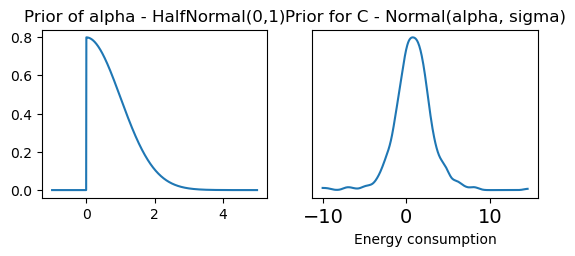

In [68]:
np.random.seed(rng)

n_samples = 1000
ax1 = plt.subplot(2, 2, (1,1))
x = np.linspace(-1,5,n_samples)
alpha_sample = stats.halfnorm.pdf(x, 0,1)
sigma_sample = stats.expon.pdf(x, 1)
ax1.plot(x, alpha_sample)
ax1.set_title("Prior of alpha - HalfNormal(0,1)")

ax2 = plt.subplot(2, 2, (2,2))
alpha_sample = stats.halfnorm.rvs(loc=0, scale=1, size=n_samples)
sigma_sample = stats.expon.rvs(1, size=n_samples)
prior_h = stats.norm.rvs(loc=alpha_sample, scale=sigma_sample)
# prior_h = stats.truncnorm()
az.plot_kde(
    prior_h, 
    ax=ax2
)
ax2.set_xlabel("Energy consumption")
# ax2.set_xlim(0, 20)
ax2.set_yticks([]);
ax2.set_title("Prior for C - Normal(alpha, sigma)")
plt.show()

Looks a lot more reasonable, $\alpha$ can no longer be negative which better fits our domain knowledge. Additionally, the prior of $C$ is situated to the right of 0 which is preferable for the same reason as $\alpha$.

Next, we will consider the sampling process starting with a trace plot:

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>]], dtype=object)

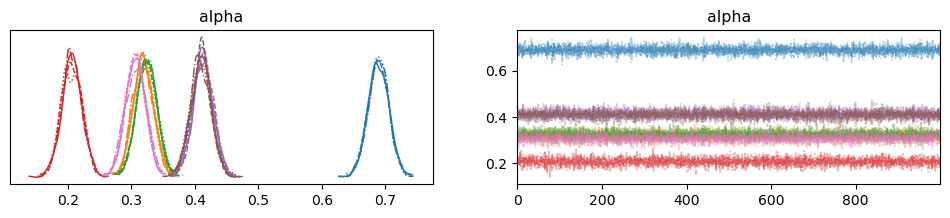

In [69]:
az.plot_trace(trace_h1b, var_names=["alpha"])

Looking at the plot trace - the sampling process looks successful. Specfically, in the right hand side plot we see good mixing in (read: *zig zagging*) and good convergance (chains are sticking to the same high probability areas). 

In [70]:
az.summary(trace_h1b, var_names=["alpha"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.689,0.016,0.659,0.719,0.0,0.0,5630.0,3333.0,1.0
alpha[1],0.319,0.016,0.289,0.348,0.0,0.0,5087.0,3142.0,1.0
alpha[2],0.324,0.016,0.294,0.354,0.0,0.0,5715.0,3328.0,1.0
alpha[3],0.206,0.016,0.176,0.236,0.0,0.0,4740.0,3191.0,1.0
alpha[4],0.413,0.016,0.384,0.443,0.0,0.0,4454.0,2875.0,1.0
alpha[5],0.409,0.016,0.378,0.439,0.0,0.0,4070.0,2842.0,1.0
alpha[6],0.307,0.016,0.277,0.335,0.0,0.0,5888.0,3269.0,1.0


Looking at the summary of the simulation, firstly we see that the $\hat r$ values are all 1, again suggesting that the sampling process was successful (and similarly the effective sample size (ess_bulk) is also high). 

Interestingly, considering only the alpha parameters, we see that the mean $\alpha$ is highest for the category "*c-sharp-razor*", and the model is fairly confident (low standard deviation).

Let's take a look at the "diff" which in this model are the contrasts between the baseline, "*c-sharp-razor*", and the other applications.

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

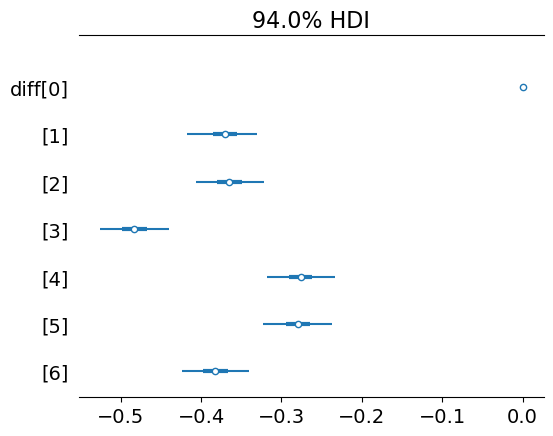

In [71]:
az.plot_forest(trace_h1b, var_names=["diff"], combined=True)

Recall that $0$ (zero) is the application "*c-sharp-razor*". We see from the forest plot of contrasts above that they are all sitting well to the left of 0.0, meaning that the energy consumption of "*c-sharp-razor*" is higher than all the other language/frameworks. We are able to reject hypothesis 1.

------

Posterior predictive check - let's see how well the model can recreate the data.

First we sample the posterior using pymc

In [72]:
with m_h1b:
    pm.sample_posterior_predictive(trace_h1b, extend_inferencedata=True, random_seed=rng)

Sampling: [C]


Output()

array([<Axes: xlabel='C'>], dtype=object)

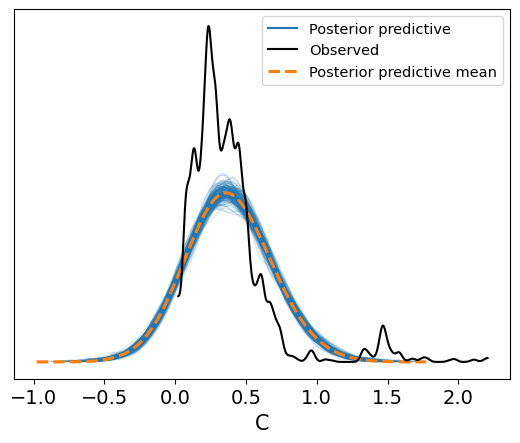

In [73]:
_, ax = plt.subplots()
az.plot_ppc(trace_h1b, num_pp_samples = 200, ax=ax)

Looking at the posterior predictive we see that although the peak of our model isn't nearly as pronounced as the "observed" the location and width of the peak match that of the observed data.

### Improving the model



Looking at the posterior predictive check we are still not happy with the model. It severely underestimates the peak and the outcome variable can still be negative.

Looks Normal distribution might not fit the data, we think it looks like a LogNormal distribution. It starts above 0, rapidly increasing peak.

$$

\begin{aligned}
    C &\sim \text{LogNormal}(\mu, \sigma) \\
    \mu &\sim \alpha_{[A[i]]} \\
    \alpha &\sim \text{Normal}(0,1) \\
    \sigma &\sim \text{Exponential}(1)
\end{aligned}

$$



In [74]:
with pm.Model() as m_h1_lognormal:
    sigma = pm.Exponential("sigma", 1)
    # shape defines a vector size (+1 because ids start from zero)
    # we will have four different mu's for K
    mu = pm.Normal("mu", 0, 1, shape=(df["A"].max() + 1,))
    # it is crazy implicit how pymc matches rows in d["clade_id"] and d["K"]
    consumption = pm.LogNormal("consumption", mu[df["A"].values], sigma, observed=df["energy_consumption"])

    trace_h1_lognormal = pm.sample(random_seed = rng, idata_kwargs = { 'log_likelihood': True })
    pm.sample_posterior_predictive(trace_h1_lognormal, extend_inferencedata=True, random_seed=rng)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [consumption]


Output()

<Axes: xlabel='consumption'>

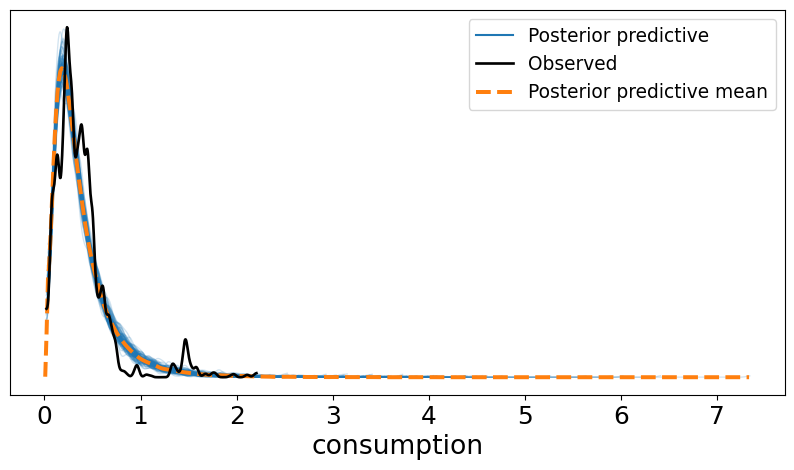

In [75]:
az.plot_ppc(trace_h1_lognormal, num_pp_samples=100, figsize=(10, 5), random_seed=42)

Look at the beauty. Compared to the normal distribution our new posterior predictive check creates the data much better!


Let's try to compare the two models!

In [80]:
az.compare({'normal':trace_h1b, 'lognormal':trace_h1_lognormal}, ic='waic')

/home/chobbie/anaconda3/envs/prpro-2025/lib/python3.12/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
lognormal,0,372.824999,8.924437,0.000000,0.946106,41.554404,0.000000,False,log
normal,1,-189.312667,10.915078,562.137667,0.053894,60.314034,44.210773,True,log


We see that the model using a lognormal likelihood has a better predictive capability. 
- elpd_waic is higher (because we are not on deviance scale). 
- p_waic (effective parameters) is also lower 
- weight = bigger

In [81]:
az.summary(trace_h1_lognormal)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],-0.780,0.040,-0.854,-0.703,0.001,0.0,4608.0,3273.0,1.0
mu[1],-1.389,0.041,-1.472,-1.318,0.001,0.0,4806.0,3339.0,1.0
mu[2],-1.267,0.040,-1.341,-1.192,0.000,0.0,6457.0,3168.0,1.0
mu[3],-1.727,0.040,-1.804,-1.655,0.001,0.0,5031.0,3242.0,1.0
mu[4],-0.964,0.039,-1.036,-0.888,0.001,0.0,5654.0,3352.0,1.0
mu[5],-1.063,0.040,-1.137,-0.986,0.001,0.0,5311.0,3138.0,1.0
mu[6],-1.281,0.040,-1.357,-1.206,0.001,0.0,4937.0,3137.0,1.0
sigma,0.671,0.011,0.652,0.692,0.000,0.0,6012.0,3131.0,1.0


What happens if we condition on endpoint?

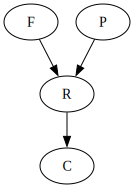

In [77]:
from causalgraphicalmodels import CausalGraphicalModel

potential1 = CausalGraphicalModel(["P", "F", "R","C"], [("P", "R"), ("F", "R"), ("R", "C")])
potential1.draw()
